In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install -U ppscore

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use("fivethirtyeight")
import seaborn as sns

In [4]:
import sklearn

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.inspection import permutation_importance
import ppscore as pps

In [7]:
df = pd.read_csv('ads.csv')

In [8]:
df.head()


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad,city,province,category
0,68.95,35,432837300.0,256.09,Perempuan,3/27/2016 0:53,No,Jakarta Timur,Daerah Khusus Ibukota Jakarta,Furniture
1,80.23,31,479092950.0,193.77,Laki-Laki,4/4/2016 1:39,No,Denpasar,Bali,Food
2,69.47,26,418501580.0,236.50,Perempuan,3/13/2016 20:35,No,Surabaya,Jawa Timur,Electronic
3,74.15,29,383643260.0,245.89,Laki-Laki,1/10/2016 2:31,No,Batam,Kepulauan Riau,House
4,68.37,35,517229930.0,225.58,Perempuan,6/3/2016 3:36,No,Medan,Sumatra Utara,Finance


In [9]:
print(f'Rows, Cols: {df.shape[0], df.shape[1]}')
df.info()

Rows, Cols: (1000, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  987 non-null    float64
 1   Age                       1000 non-null   int64  
 2   Area Income               987 non-null    float64
 3   Daily Internet Usage      989 non-null    float64
 4   Male                      997 non-null    object 
 5   Timestamp                 1000 non-null   object 
 6   Clicked on Ad             1000 non-null   object 
 7   city                      1000 non-null   object 
 8   province                  1000 non-null   object 
 9   category                  1000 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 85.9+ KB


In [10]:
num_cols = list(df.select_dtypes('number').columns)
print(num_cols)

['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']


In [12]:
df.select_dtypes("number").describe().T

,count,mean,std,min,25%,50%,75%,max
Daily Time Spent on Site,987.0,6.492952e+01,1.584470e+01,32.60,5.127000e+01,6.811000e+01,7.846000e+01,9.143000e+01
Age,1000.0,3.600900e+01,8.785562e+00,19.00,2.900000e+01,3.500000e+01,4.200000e+01,6.100000e+01
Area Income,987.0,3.848647e+08,9.407999e+07,97975500.00,3.286330e+08,3.990683e+08,4.583554e+08,5.563936e+08
Daily Internet Usage,989.0,1.798636e+02,4.387014e+01,104.78,1.387100e+02,1.826500e+02,2.187900e+02,2.670100e+02


In [13]:
df.select_dtypes(object).describe().T

,count,unique,top,freq
Male,997,2,Perempuan,518
Timestamp,1000,997,5/26/2016 15:40,2
Clicked on Ad,1000,2,No,500
city,1000,30,Surabaya,64
province,1000,16,Daerah Khusus Ibukota Jakarta,253
category,1000,10,Otomotif,112


In [14]:
df.isnull().any()

Daily Time Spent on Site     True
Age                         False
Area Income                  True
Daily Internet Usage         True
Male                         True
Timestamp                   False
Clicked on Ad               False
city                        False
province                    False
category                    False
dtype: bool

In [15]:
df.isnull().sum()

Daily Time Spent on Site    13
Age                          0
Area Income                 13
Daily Internet Usage        11
Male                         3
Timestamp                    0
Clicked on Ad                0
city                         0
province                     0
category                     0
dtype: int64

In [16]:
# Daily Time Spent on Site and Daily Internet Usage columns have approximately symmetric skewness, so they are filled with the mean
df['Daily Time Spent on Site'].fillna(df['Daily Time Spent on Site'].mean(), inplace=True)
df['Daily Internet Usage'].fillna(df['Daily Internet Usage'].mean(), inplace=True)
# Area Income column has moderately skewness, so they are filled with the median
df['Area Income'].fillna(df['Area Income'].median(), inplace=True)
# the Male column is filled with the mode value because it is a category column
df['Male'].fillna(df['Male'].mode()[0], inplace=True)

In [17]:
df.isnull().any()

Daily Time Spent on Site    False
Age                         False
Area Income                 False
Daily Internet Usage        False
Male                        False
Timestamp                   False
Clicked on Ad               False
city                        False
province                    False
category                    False
dtype: bool

In [18]:
df.duplicated().any()

False

In [19]:
num_cols = list(df.select_dtypes("number").columns)
print("Num Features Length",len(num_cols), ":", num_cols)

Num Features Length 4 : ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']


In [20]:
num_cols_skewness = df[num_cols].skew()

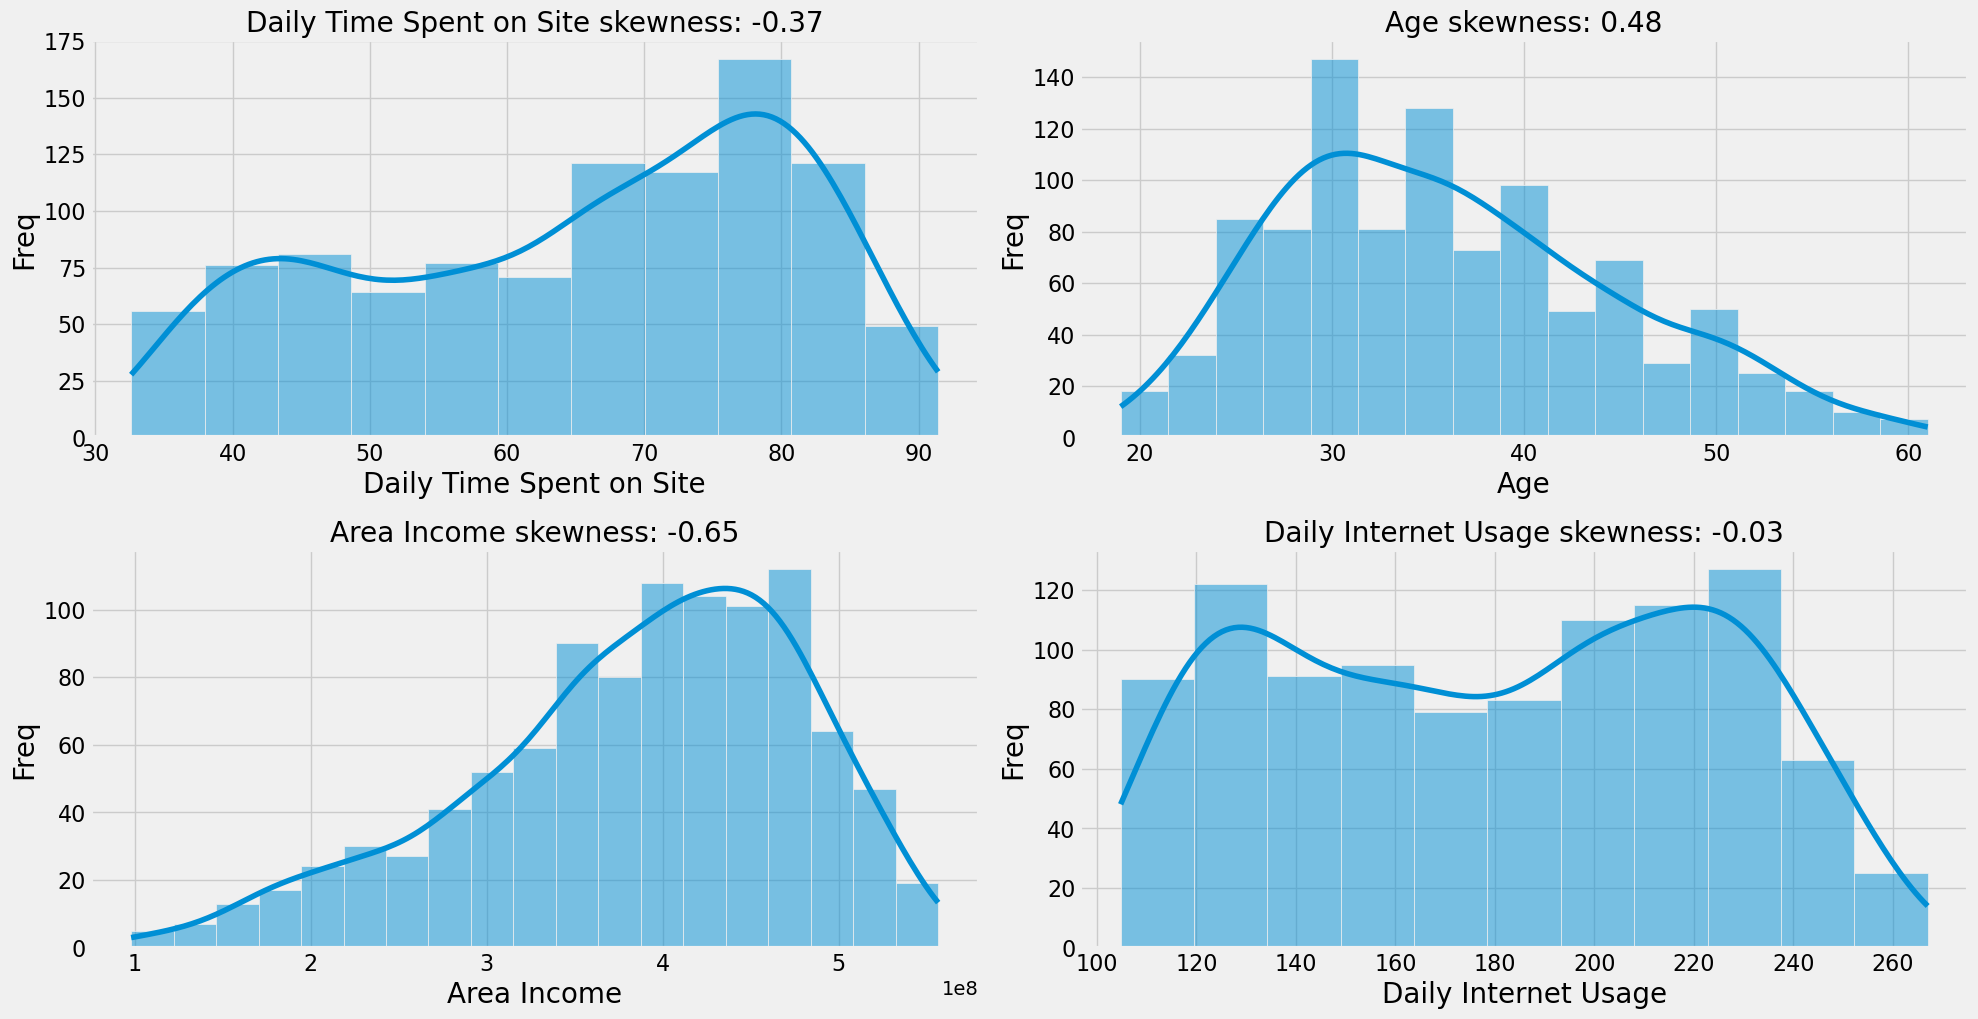

In [21]:
plt.figure(figsize=(20, 20))
for i in range(len(num_cols)):
    plt.subplot(len(num_cols)//1, 2, i+1)
    ax = sns.histplot(
        df[num_cols[i]],
        kde = True
    )
    ax.set_xlabel(str(num_cols[i]), fontsize = 20)
    ax.set_ylabel("Freq", fontsize = 20)
    ax.tick_params(labelsize=16)
    ax.set_title(str(num_cols[i]) + ' skewness: ' + str(round(num_cols_skewness[i], 2)))
plt.tight_layout()
plt.savefig('num histplot.png', bbox_inches = 'tight', dpi = 300, transparent = True)
plt.show()

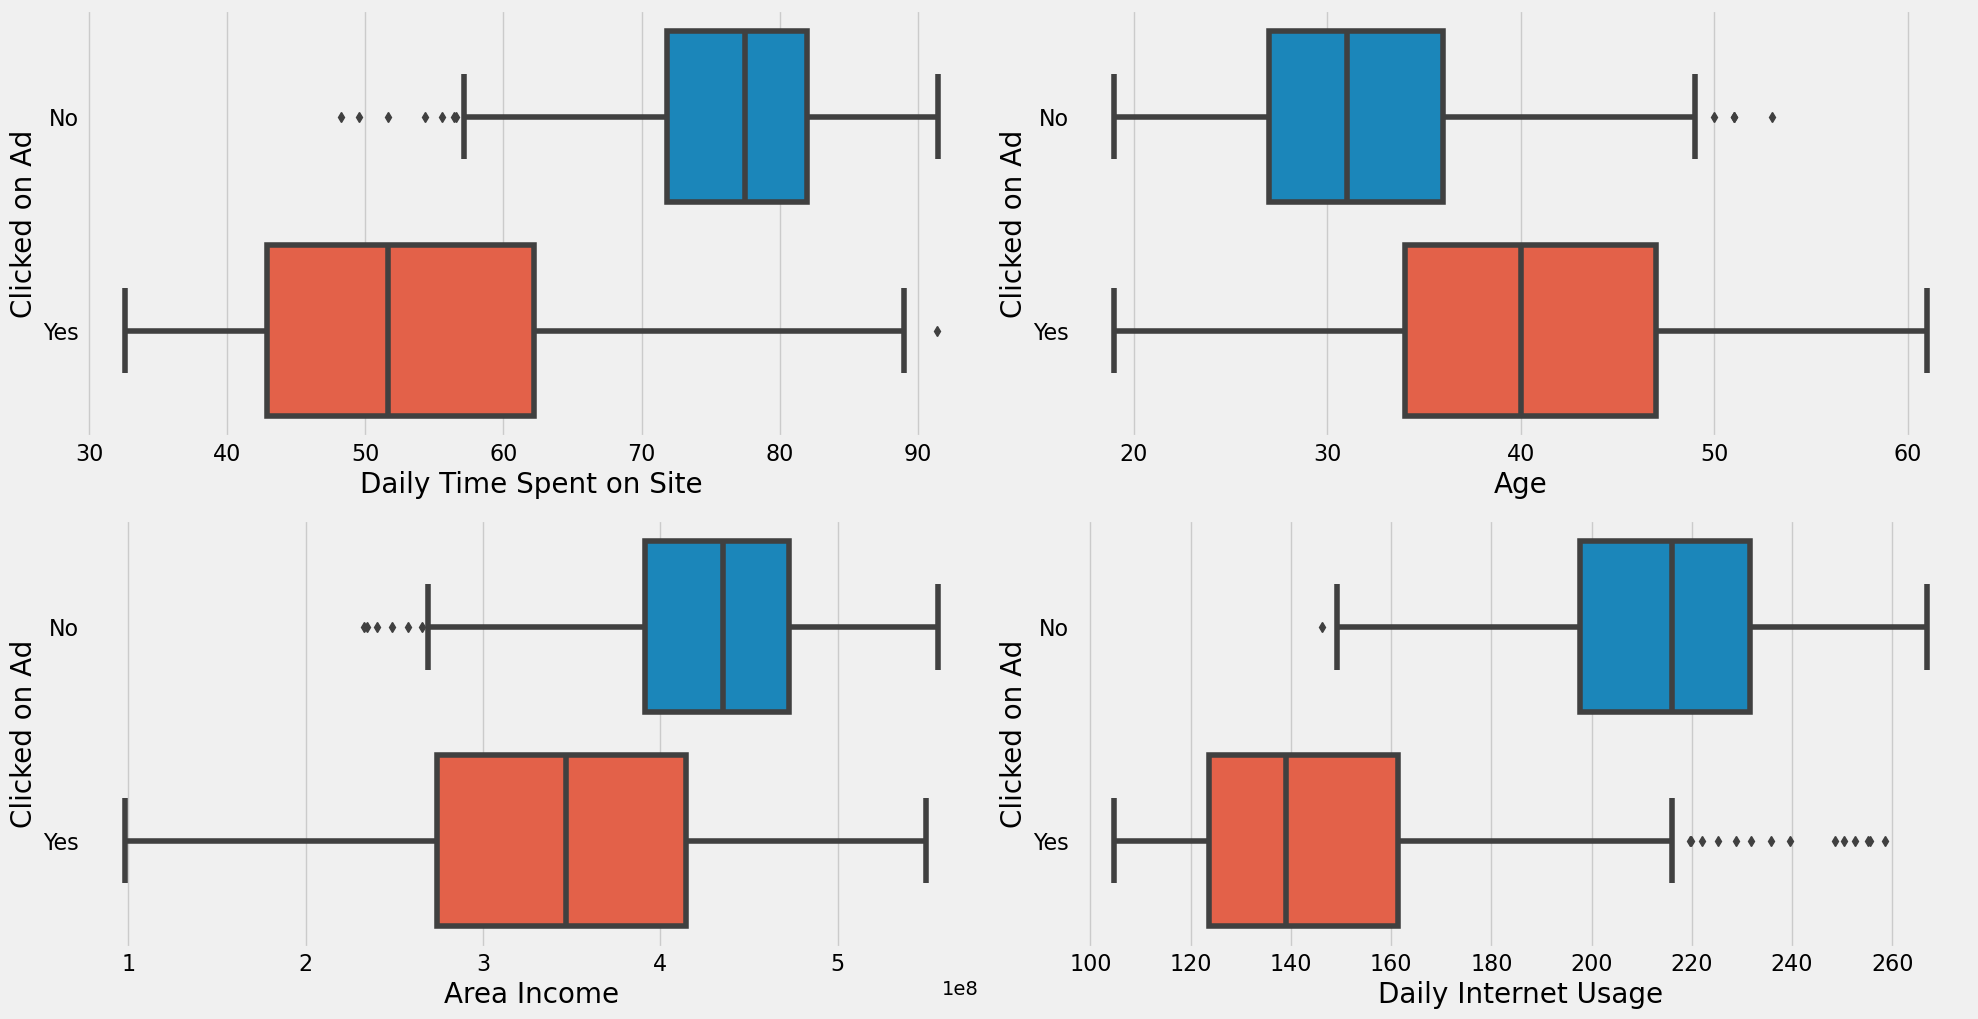

In [26]:
plt.figure(figsize=(20, 20))
for i in range(len(num_cols)):
    plt.subplot(len(num_cols)//1, 2, i+1)
    ax = sns.boxplot(
        x = df[num_cols[i]],
        y = df["Clicked on Ad"],
    )
    ax.set_xlabel(str(num_cols[i]), fontsize = 20)
    ax.set_ylabel("Clicked on Ad", fontsize = 20)
    ax.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig('num boxplot biv.png', bbox_inches = 'tight', dpi = 300, transparent = True)
plt.show()

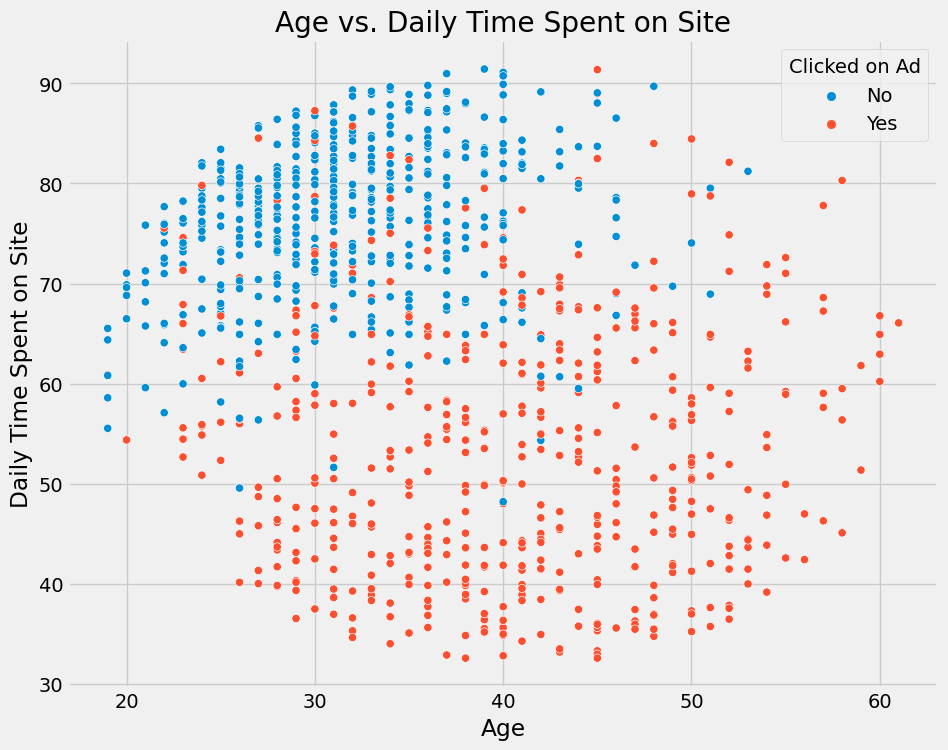

In [27]:
plt.figure(figsize=(10,8))
plot = sns.scatterplot(x = 'Age', y= 'Daily Time Spent on Site', hue='Clicked on Ad', data = df)
plt.title('Age vs. Daily Time Spent on Site')
plt.show()

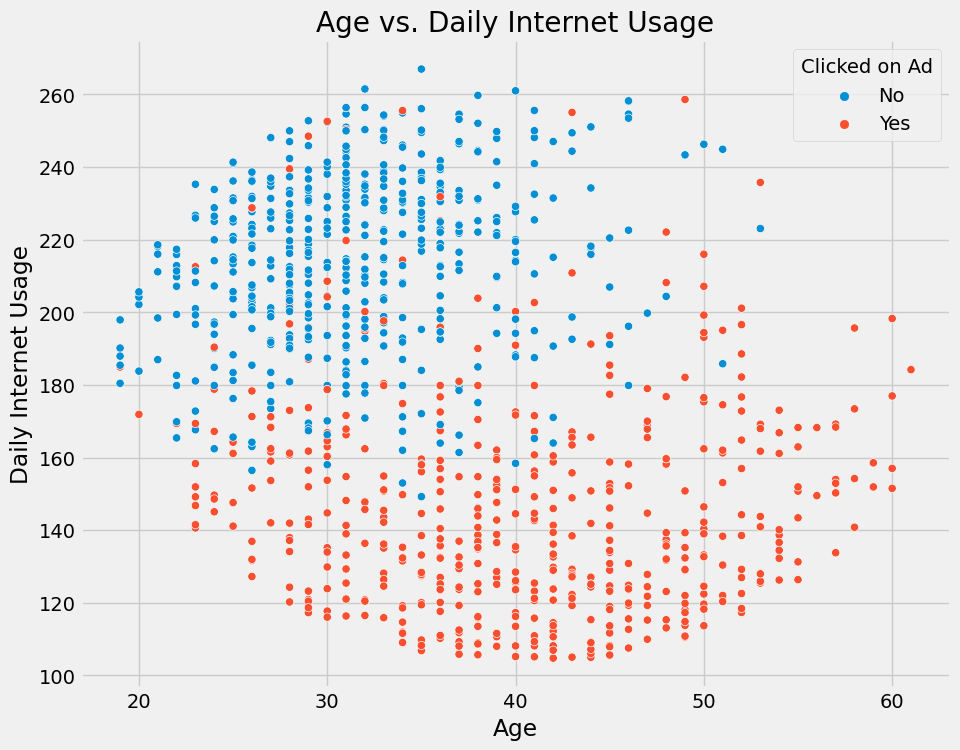

In [28]:
plt.figure(figsize=(10,8))
plot = sns.scatterplot(x = 'Age', y= 'Daily Internet Usage', hue='Clicked on Ad', data = df)
plt.title('Age vs. Daily Internet Usage')
plt.show()

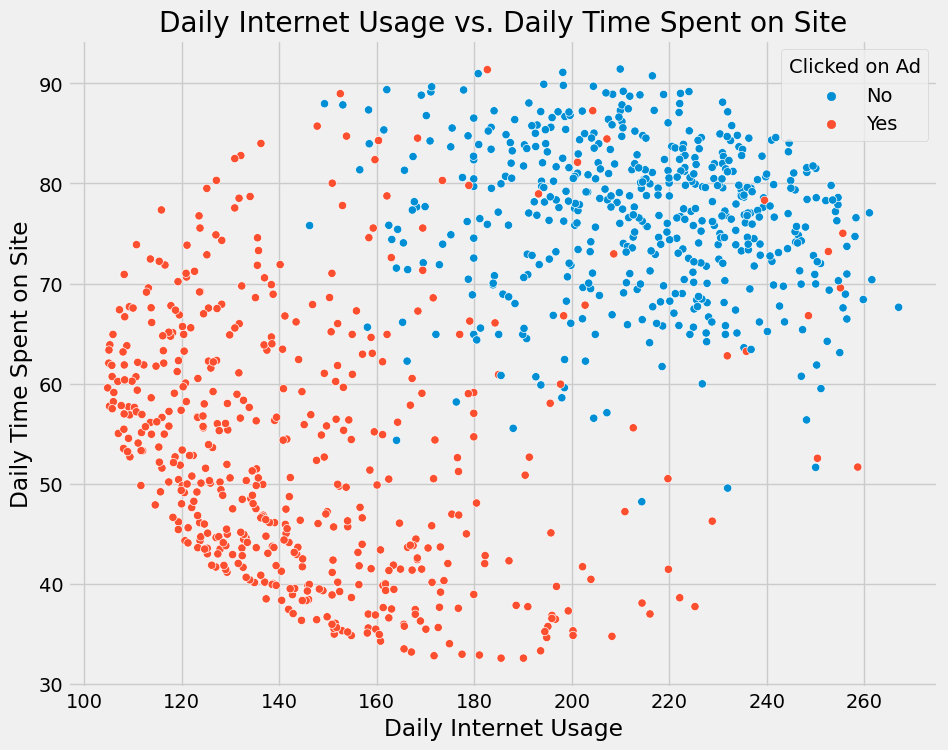

In [29]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=df['Daily Internet Usage'],y=df['Daily Time Spent on Site'],hue=df['Clicked on Ad'])
plt.title('Daily Internet Usage vs. Daily Time Spent on Site')
plt.show()

In [30]:
df.groupby(['Clicked on Ad']).median()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage
Clicked on Ad,,,,
No,77.455,31.0,435281665.0,216.015
Yes,51.630,40.0,346928575.0,139.015


In [32]:
cat_cols = list(df.select_dtypes(object).drop(columns=["Clicked on Ad"]).columns)
cat_cols[2], cat_cols[1] = cat_cols[1], cat_cols[2]
print("Cat Features Length",len(cat_cols), ":", cat_cols)

Cat Features Length 5 : ['Male', 'city', 'Timestamp', 'province', 'category']


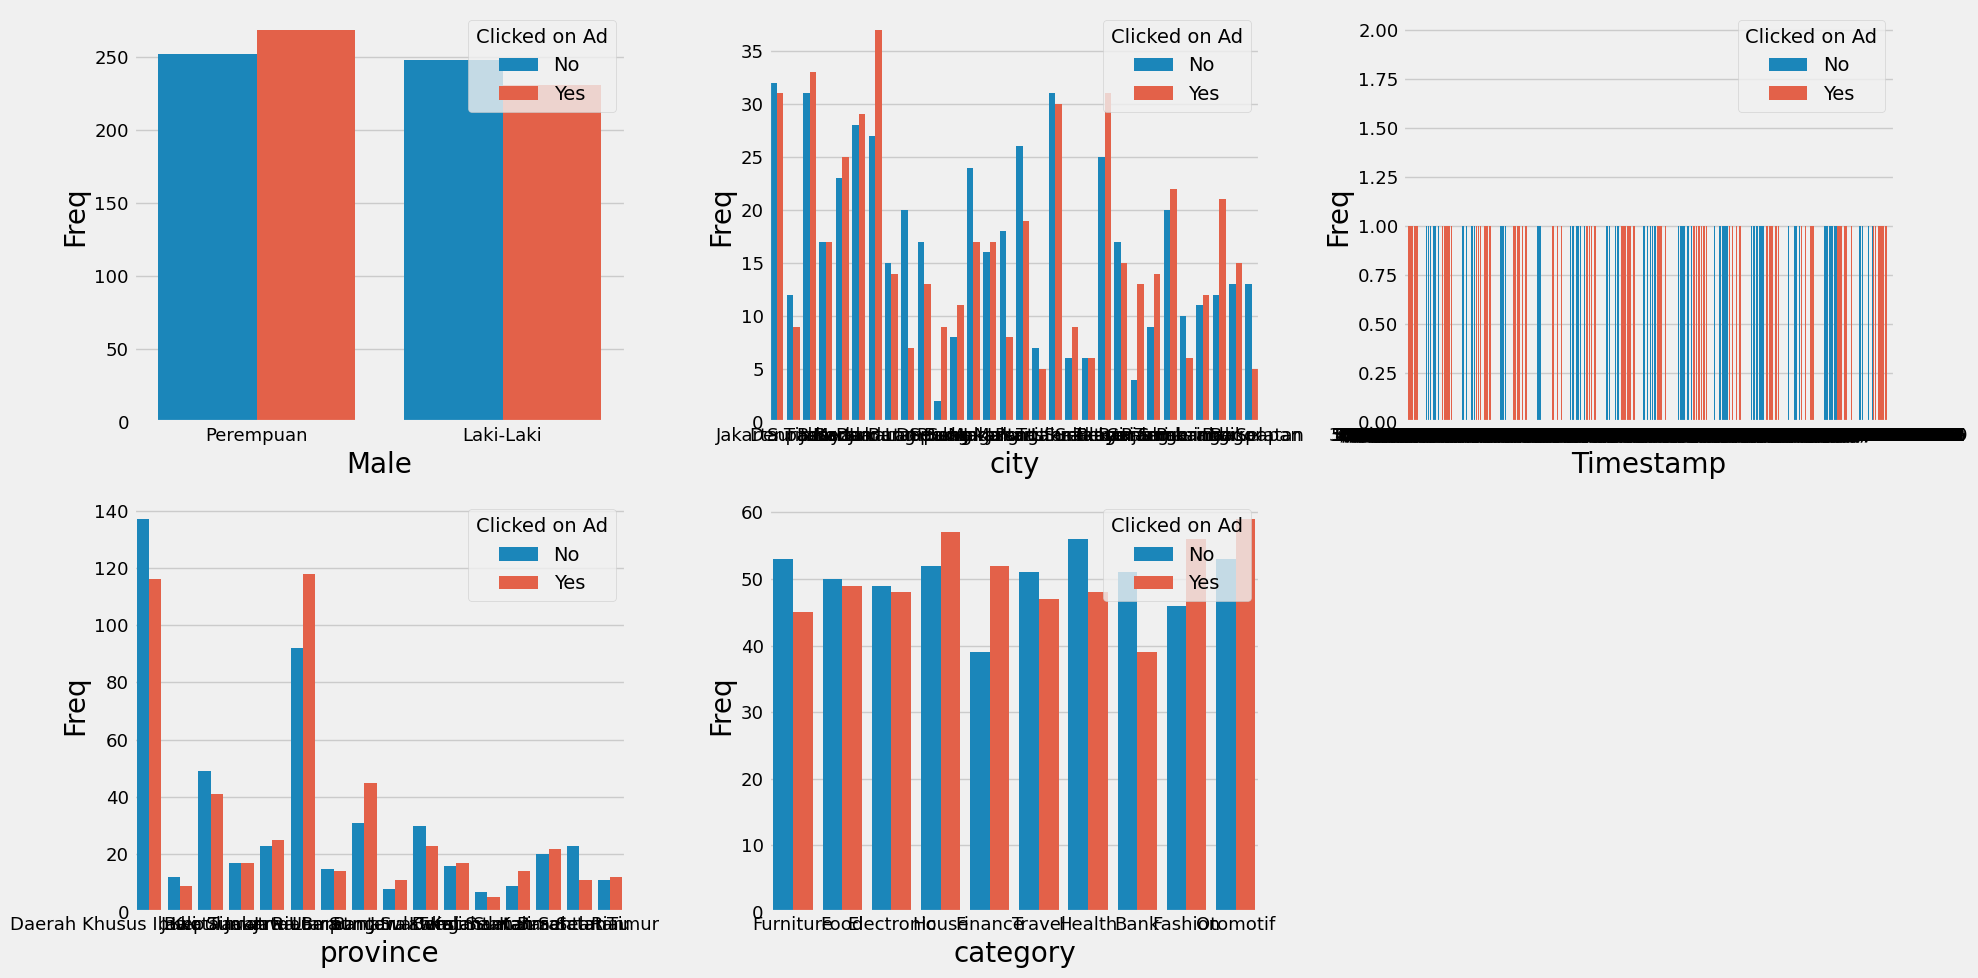

In [33]:
plt.figure(figsize=(20, 10))
for i in range(0, len(cat_cols)):
    plt.subplot(2, 3, i+1)
    ax = sns.countplot(x = df[cat_cols[i]], hue=df['Clicked on Ad'], palette=["C0", "C1"], orient='v')
    ax.set_xlabel(str(cat_cols[i]), fontsize = 20)
    ax.tick_params(labelsize=13)
    ax.set_ylabel("Freq", fontsize = 20)
    plt.tight_layout()
plt.savefig("count plot.jpg", dpi=150)

<Figure size 2000x2000 with 0 Axes>

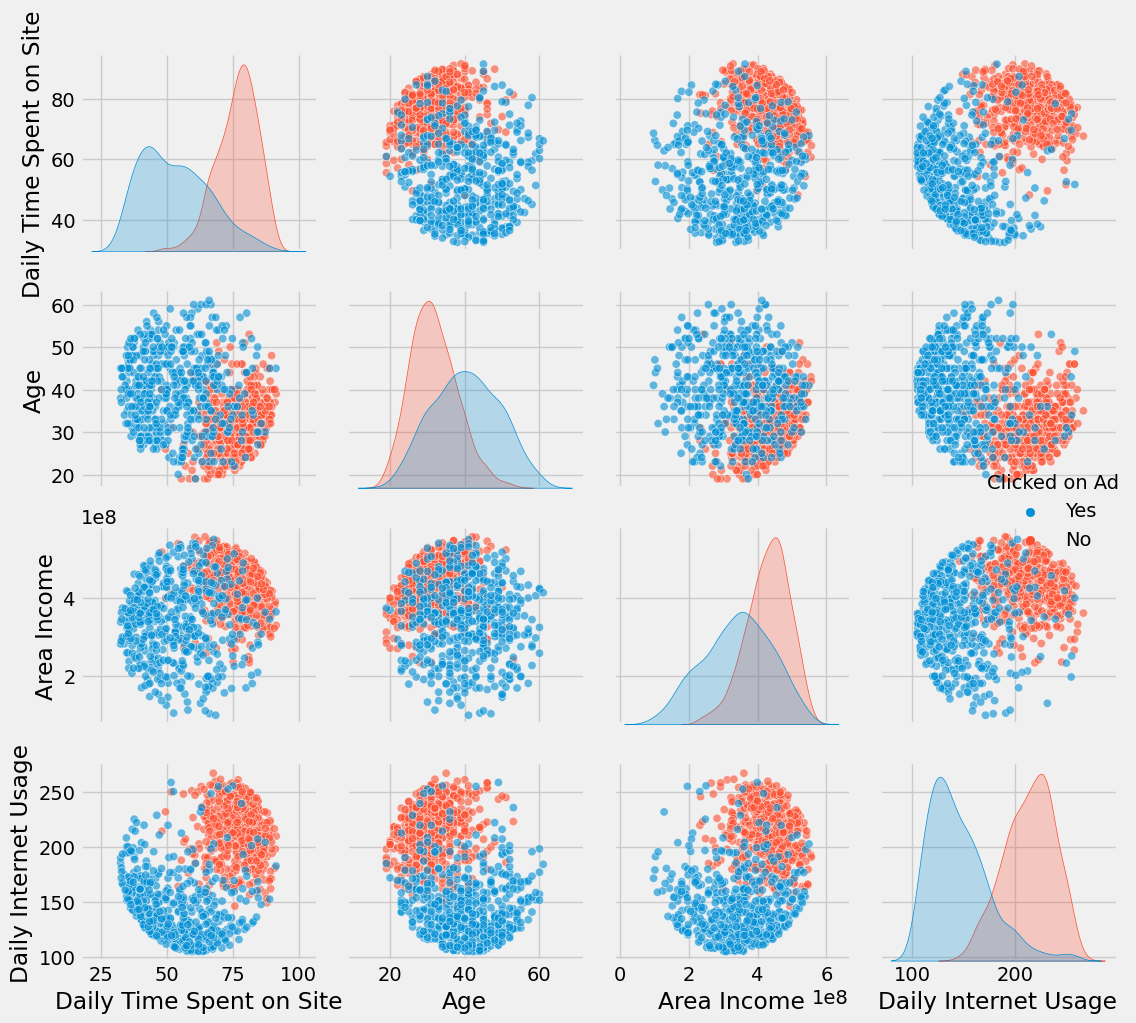

In [34]:
df_sort = df.sort_values(["Clicked on Ad"], ascending = True)
plt.figure(figsize=(20, 20))
ax = sns.pairplot(
    df_sort,
    hue = "Clicked on Ad",
    hue_order = ["Yes", "No"],
    palette = {"Yes":"C0", "No":"C1"},
    kind="scatter", plot_kws={"alpha": 0.6, "edgecolor":"white"},
)
plt.tight_layout()
plt.savefig('num pairplot.png', bbox_inches = 'tight', dpi = 300, transparent = True)
plt.show()

In [35]:
df.corr()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage
Daily Time Spent on Site,1.000000,-0.329006,0.304718,0.513470
Age,-0.329006,1.000000,-0.177965,-0.368997
Area Income,0.304718,-0.177965,1.000000,0.333911
Daily Internet Usage,0.513470,-0.368997,0.333911,1.000000


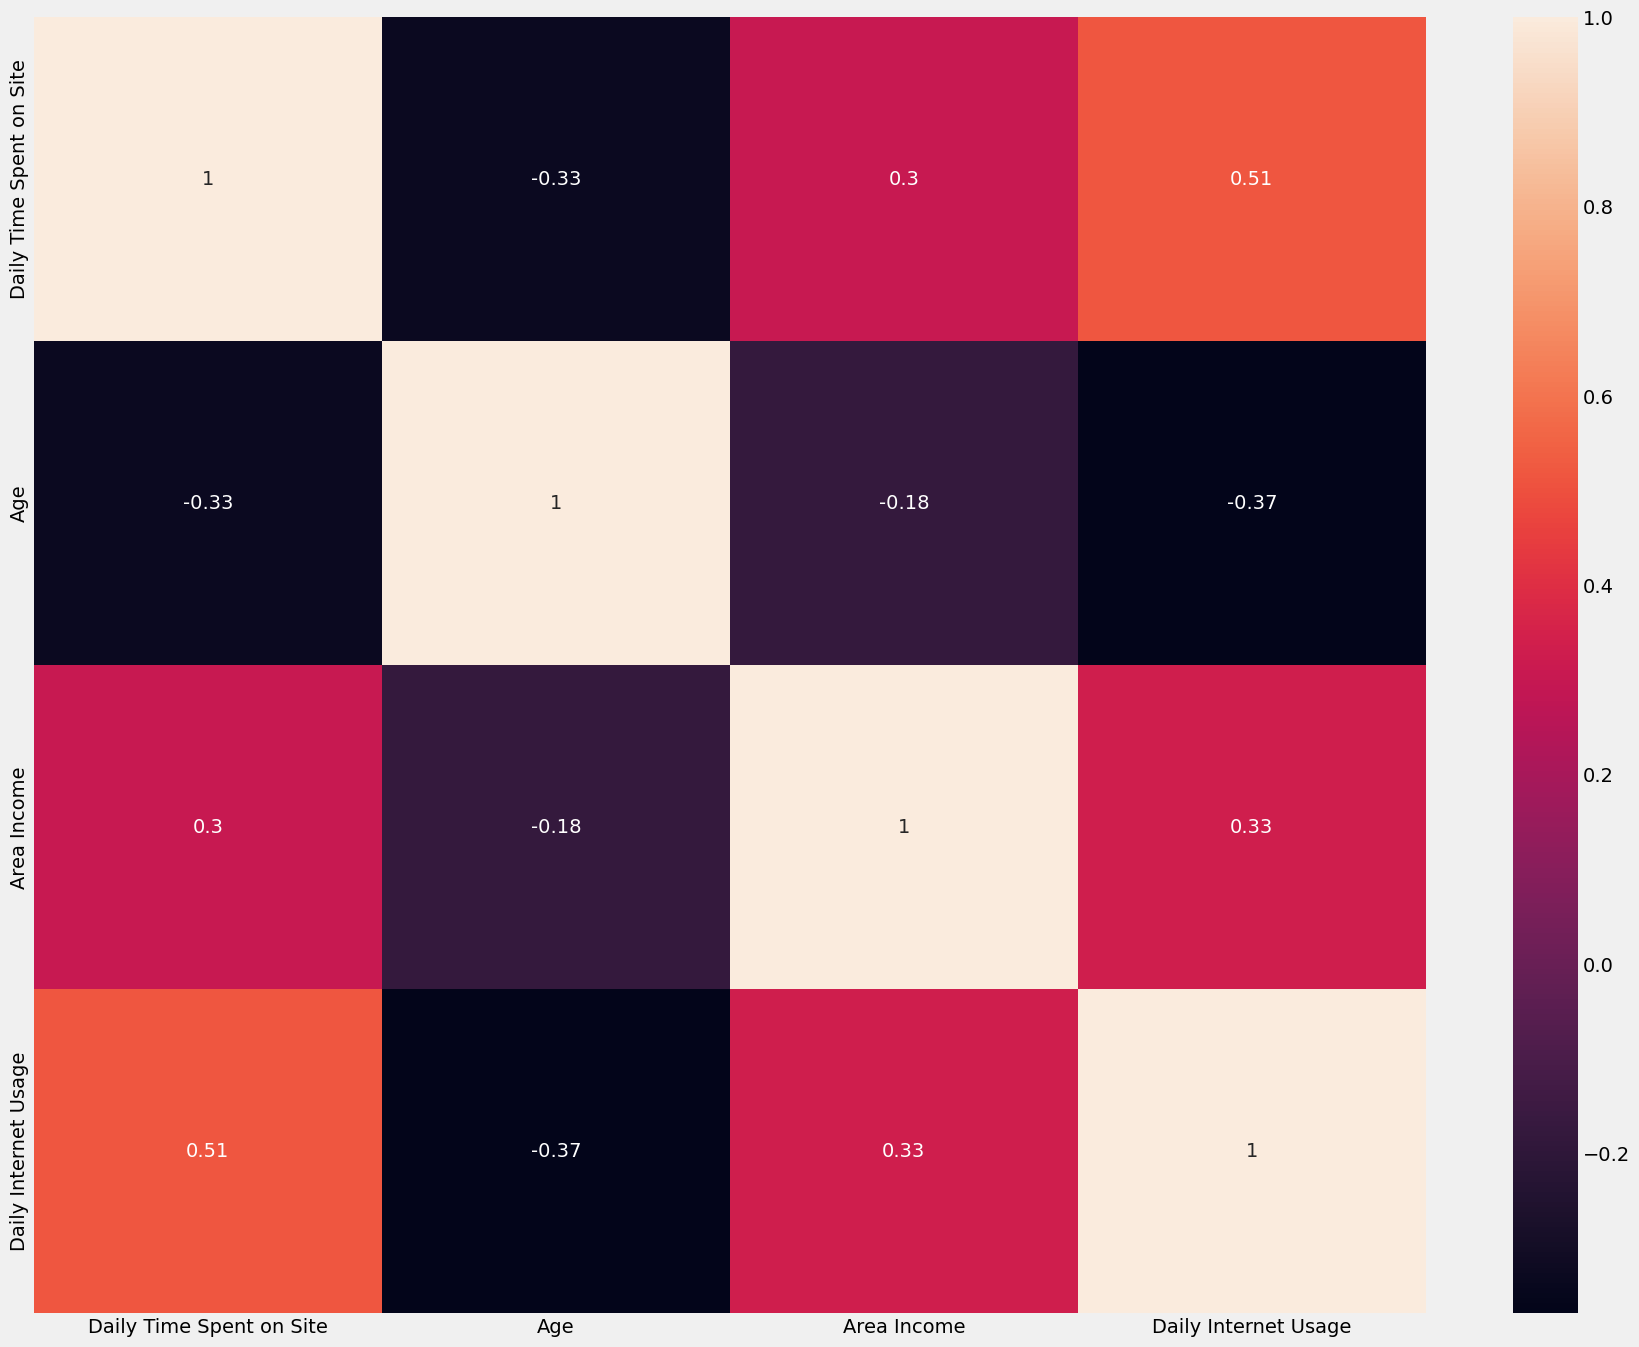

In [36]:
plt.figure(figsize=(20,16))
svm = sns.heatmap(df.corr(),annot=True)
plt.show()
figure = svm.get_figure()    
figure.savefig("heatmap.jpg", dpi=150)

In [37]:
df_pps = pps.matrix(df)
matrix_df = df_pps[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

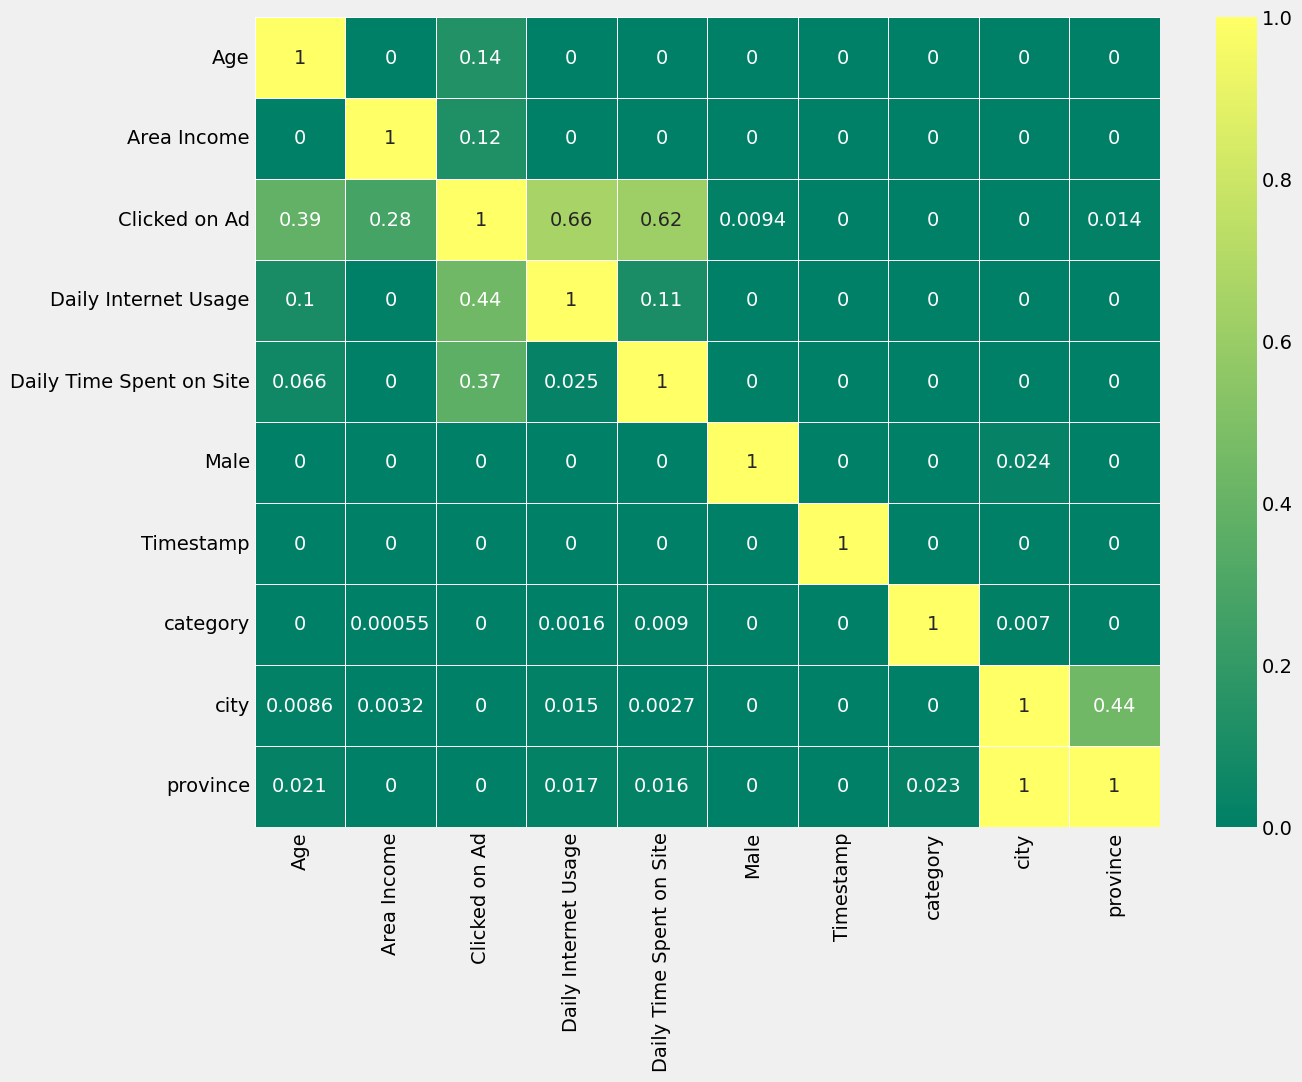

In [38]:
plt.figure(figsize=(13,10))
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="summer", linewidths=0.5, annot=True)
plt.xlabel(None)
plt.ylabel(None)
plt.show()

In [39]:
df["target"] = df["Clicked on Ad"].apply(lambda x: 1 if x == "Yes" else 0)
df.drop(columns=["Clicked on Ad"], inplace = True)

In [40]:
# Extract datetime variables using timestamp column and converting timestamp column into datatime object in order to extract new features
df['Timestamp'] = pd.to_datetime(df['Timestamp']) 
# Creates a new column called Month
df['Month'] = df['Timestamp'].dt.month 
# Creates a new column called Day
df['Day'] = df['Timestamp'].dt.day     
# Creates a new column called Weekday with sunday as 6 and monday as 0
df["Weekday"] = df['Timestamp'].dt.dayofweek 

# Dropping timestamp column to avoid redundancy
df = df.drop(['Timestamp'], axis=1) # deleting timestamp

In [41]:
print('\nData distribution before outlier handling: ')
print(df[['Area Income','Month', 'Day', 'Weekday']].describe())


Data distribution before outlier handling: 
        Area Income        Month          Day      Weekday
count  1.000000e+03  1000.000000  1000.000000  1000.000000
mean   3.850493e+08     3.817000    15.484000     3.064000
std    9.347971e+07     1.926973     8.734073     1.998474
min    9.797550e+07     1.000000     1.000000     0.000000
25%    3.298201e+08     2.000000     8.000000     1.000000
50%    3.990683e+08     4.000000    15.000000     3.000000
75%    4.566932e+08     5.000000    23.000000     5.000000
max    5.563936e+08     7.000000    31.000000     6.000000


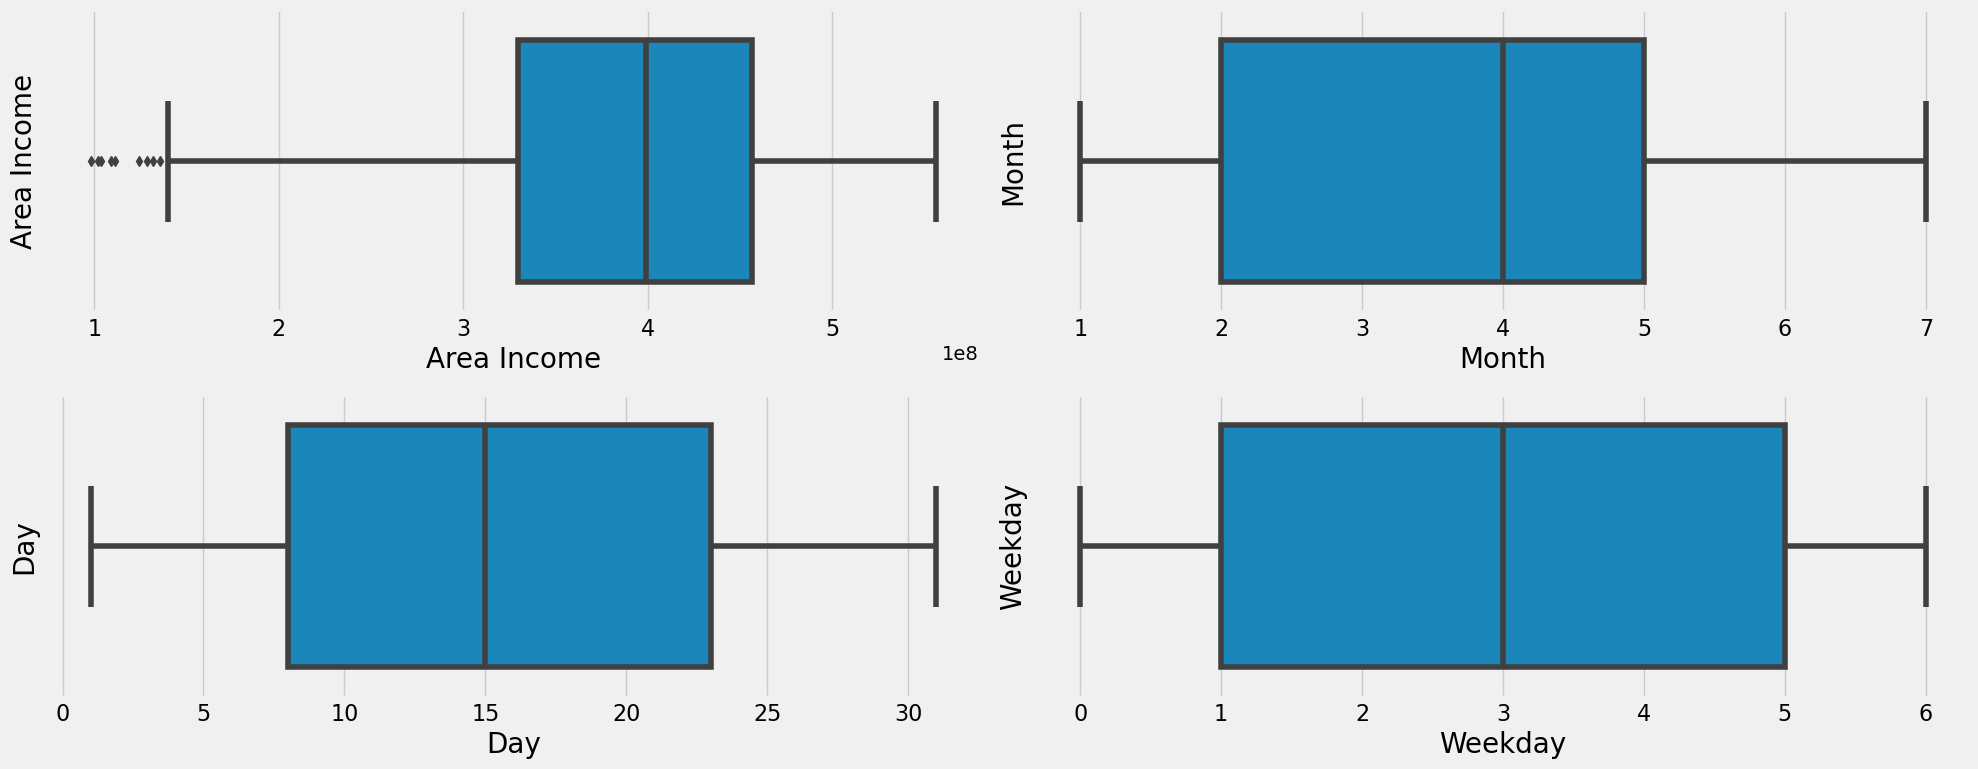

In [42]:
num = ['Area Income','Month', 'Day', 'Weekday']
plt.figure(figsize=(20, 15))
for i in range(len(num)):
    plt.subplot(len(num)//1, 2, i+1)
    ax = sns.boxplot(
        x = df[num[i]]
    )
    ax.set_xlabel(str(num[i]), fontsize = 20)
    ax.set_ylabel(str(num[i]), fontsize = 20)
    ax.tick_params(labelsize=16)
plt.tight_layout()
#plt.savefig('num boxplot.png', bbox_inches = 'tight', dpi = 300, transparent = True)
plt.show()

In [43]:
# Handling with IQR 
Q1 = (df[['Area Income']]).quantile(0.25)
Q3 = (df[['Area Income']]).quantile(0.75)

IQR = Q3 - Q1
print('The IQR value of each variable is: ')
print(IQR)

maximum = Q3 + (1.5*IQR)
print('Maximum Value of each Variable is:')
print(maximum)

minimum = Q1 - (1.5*IQR)
print('\nManimum Value of each Variable is:')
print(minimum)
more_than = (df > maximum)
lower_than = (df < minimum)
df = df .mask(more_than, maximum, axis=1)
df = df.mask(lower_than, minimum, axis=1)
print('\nData distribution after outlier handling: ')
print(df[['Area Income']].describe())

The IQR value of each variable is: 
Area Income    126873075.0
dtype: float64
Maximum Value of each Variable is:
Area Income    647002825.0
dtype: float64

Manimum Value of each Variable is:
Area Income    139510525.0
dtype: float64

Data distribution after outlier handling: 
        Area Income
count  1.000000e+03
mean   3.852616e+08
std    9.288397e+07
min    1.395105e+08
25%    3.298201e+08
50%    3.990683e+08
75%    4.566932e+08
max    5.563936e+08


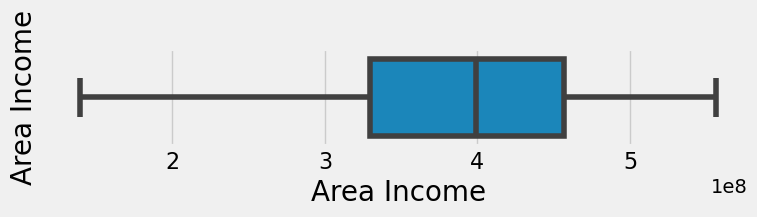

In [44]:
num = ['Area Income']
plt.figure(figsize=(15, 2))
for i in range(len(num)):
    plt.subplot(len(num)//1, 2, i+1)
    ax = sns.boxplot(
        x = df[num[i]]
    )
    ax.set_xlabel(str(num[i]), fontsize = 20)
    ax.set_ylabel(str(num[i]), fontsize = 20)
    ax.tick_params(labelsize=16)
plt.tight_layout()
#plt.savefig('num boxplot.png', bbox_inches = 'tight', dpi = 300, transparent = True)
plt.show()

In [45]:
df.drop(columns=['city','province'],inplace = True)

In [46]:
for cat in ['Male', 'category']:
    onehots = pd.get_dummies(df[cat], prefix=cat)
    df = df.join(onehots)


In [47]:
df = df.drop(columns= ['Male', 'category'])
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   target                    1000 non-null   int64  
 5   Month                     1000 non-null   int64  
 6   Day                       1000 non-null   int64  
 7   Weekday                   1000 non-null   int64  
 8   Male_Laki-Laki            1000 non-null   uint8  
 9   Male_Perempuan            1000 non-null   uint8  
 10  category_Bank             1000 non-null   uint8  
 11  category_Electronic       1000 non-null   uint8  
 12  category_Fashion          1000 non-null   uint8  
 13  category_Finance          1000 non-null   uint8  
 14  category_

In [48]:
X = df.drop(columns=['target'])
y = df['target'] # target / label

In [49]:
#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("AUC (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("AUC (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [51]:
# List of hyperparameter 
penalty = ['l2','l1','elasticnet']
C = [0.0001, 0.001, 0.002] # Inverse of regularization strength; smaller values specify stronger regularization.
solver = ['liblinear', 'newton-cg','lbfgs']
multi_class= ['multinomial']
hyperparameters = dict(penalty=penalty, C=C, solver=solver, multi_class=multi_class)

# Initiation model
logres = LogisticRegression(random_state=42) # Init Logres dengan Gridsearch, cross validation = 5
logreg_grid = GridSearchCV(logres, hyperparameters, cv=5, scoring='accuracy')

# Fitting Model & Evaluation
logreg_grid.fit(X_train, y_train)
y_pred = logreg_grid.predict(X_test)
eval_classification(logreg_grid)

Accuracy (Train Set): 0.95
Accuracy (Test Set): 0.95
Precision (Train Set): 0.98
Precision (Test Set): 0.99
Recall (Train Set): 0.91
Recall (Test Set): 0.92
AUC (test-proba): 0.98
AUC (train-proba): 0.99


In [52]:
# List of hyperparameter 
penalty = ['l2','l1','elasticnet']
C = [0.0001, 0.001, 0.002] # Inverse of regularization strength; smaller values specify stronger regularization.
solver = ['liblinear', 'newton-cg','lbfgs']
multi_class= ['multinomial']
hyperparameters = dict(penalty=penalty, C=C, solver=solver, multi_class=multi_class)

# Initiation model
logres = LogisticRegression(random_state=42) # Init Logres dengan Gridsearch, cross validation = 5
logreg_grid = GridSearchCV(logres, hyperparameters, cv=5, scoring='accuracy')

# Fitting Model & Evaluation
logreg_grid.fit(X_train, y_train)
y_pred = logreg_grid.predict(X_test)
eval_classification(logreg_grid)

Accuracy (Train Set): 0.95
Accuracy (Test Set): 0.95
Precision (Train Set): 0.98
Precision (Test Set): 0.99
Recall (Train Set): 0.91
Recall (Test Set): 0.92
AUC (test-proba): 0.98
AUC (train-proba): 0.99


In [53]:
show_best_hyperparameter(logreg_grid)

{'C': 0.0001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [54]:
#Re-iteration with the best parameters after the absence of overfitting and underfitting
lr_tuned = LogisticRegression(random_state=42,
                              C=0.0001,
                              penalty='l2',            
                              solver='newton-cg',
                              multi_class='multinomial'
                              ).fit(X_train, y_train)
eval_classification(lr_tuned)

Accuracy (Train Set): 0.95
Accuracy (Test Set): 0.95
Precision (Train Set): 0.98
Precision (Test Set): 0.99
Recall (Train Set): 0.91
Recall (Test Set): 0.92
AUC (test-proba): 0.98
AUC (train-proba): 0.99


In [55]:
# List of hyperparameter
param_grid = { 
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [2,4,6,7,8],
    'min_samples_split' : [2, 5], 
    'min_samples_leaf' : [1, 2] 
}

# Initiation model
dtc=DecisionTreeClassifier(random_state=42)
dtc_grid = GridSearchCV(estimator=dtc, param_grid=param_grid, cv= 5, scoring='accuracy')

# Fitting Model & Evaluation
dtc_grid.fit(X_train, y_train)
y_pred = dtc_grid.predict(X_test)
eval_classification(dtc_grid)

Accuracy (Train Set): 0.95
Accuracy (Test Set): 0.92
Precision (Train Set): 0.94
Precision (Test Set): 0.91
Recall (Train Set): 0.96
Recall (Test Set): 0.95
AUC (test-proba): 0.92
AUC (train-proba): 0.95


In [56]:
show_best_hyperparameter(dtc_grid)

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


In [57]:
dt_tuned = DecisionTreeClassifier(random_state=42, 
                                   max_depth=3, 
                                   min_samples_split=2,
                                   min_samples_leaf= 1,
                                   max_features='auto',
                                   criterion='gini').fit(X_train, y_train)

eval_classification(dt_tuned)

Accuracy (Train Set): 0.89
Accuracy (Test Set): 0.91
Precision (Train Set): 0.92
Precision (Test Set): 0.96
Recall (Train Set): 0.85
Recall (Test Set): 0.86
AUC (test-proba): 0.94
AUC (train-proba): 0.93


In [58]:
# List of hyperparameter
param_grid = { 
    'max_depth' : [2,3],
    'min_samples_split' : [2, 5, 7], 
    'min_samples_leaf' : [2, 3], 
    'n_estimators': [100, 110],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' : ['gini', 'entropy']
}

# Initiation model
rfc=RandomForestClassifier(random_state=42)
rfc_grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, scoring='accuracy')

# Fitting Model & Evaluation
rfc_grid.fit(X_train, y_train)
y_pred = rfc_grid.predict(X_test)
eval_classification(rfc_grid)

Accuracy (Train Set): 0.98
Accuracy (Test Set): 0.95
Precision (Train Set): 0.99
Precision (Test Set): 0.95
Recall (Train Set): 0.97
Recall (Test Set): 0.95
AUC (test-proba): 0.98
AUC (train-proba): 1.00


In [59]:
show_best_hyperparameter(rfc_grid)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 110, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [60]:
rf_tuned = RandomForestClassifier(random_state=42, 
                                   n_estimators=110, 
                                   max_depth=2, 
                                   criterion='gini',
                                   max_features= 'auto',
                                   min_samples_split=9, 
                                   min_samples_leaf=3).fit(X_train, y_train)
eval_classification(rf_tuned)

Accuracy (Train Set): 0.95
Accuracy (Test Set): 0.95
Precision (Train Set): 0.97
Precision (Test Set): 0.96
Recall (Train Set): 0.93
Recall (Test Set): 0.94
AUC (test-proba): 0.98
AUC (train-proba): 0.99


In [61]:
# List of hyperparameter
n_neighbors = list(range(1,40))
p=[1]
algorithm = ['brute']
hyperparameters = dict(n_neighbors=n_neighbors, p=p, algorithm=algorithm)

# Init model
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, hyperparameters, cv=5, scoring='accuracy')

# Fit Model & Evaluasi
knn_grid.fit(X_train, y_train)
y_pred = knn_grid.predict(X_test)
eval_classification(knn_grid)

Accuracy (Train Set): 0.73
Accuracy (Test Set): 0.68
Precision (Train Set): 0.78
Precision (Test Set): 0.75
Recall (Train Set): 0.64
Recall (Test Set): 0.58
AUC (test-proba): 0.72
AUC (train-proba): 0.80


In [62]:
show_best_hyperparameter(knn_grid)

{'algorithm': 'brute', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 24, 'p': 1, 'weights': 'uniform'}


In [63]:
knn_tuned = KNeighborsClassifier(n_neighbors =24, 
                                 p=1, 
                                 leaf_size=30,
                                 weights='uniform',
                                 algorithm = 'brute').fit(X_train, y_train)
eval_classification(knn_tuned)

Accuracy (Train Set): 0.73
Accuracy (Test Set): 0.68
Precision (Train Set): 0.78
Precision (Test Set): 0.75
Recall (Train Set): 0.64
Recall (Test Set): 0.58
AUC (test-proba): 0.72
AUC (train-proba): 0.80


In [64]:
# List of hyperparameter
param_grid = { 
    'learning_rate': [0.001, 0.01, 1],
    'n_estimators': [20, 60, 80],
    'algorithm' : ['SAMME.R', 'SAMME']
}

# Init model
ab = AdaBoostClassifier(random_state=42)
ab_grid = GridSearchCV(ab, param_grid, cv=5, scoring='accuracy')

# Predict & Evaluation
ab_grid.fit(X_train,y_train)
y_pred = ab_grid.predict(X_test)
eval_classification(ab_grid)

Accuracy (Train Set): 0.99
Accuracy (Test Set): 0.95
Precision (Train Set): 1.00
Precision (Test Set): 0.97
Recall (Train Set): 0.99
Recall (Test Set): 0.93
AUC (test-proba): 0.98
AUC (train-proba): 1.00


In [65]:
show_best_hyperparameter(ab_grid)

{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1, 'n_estimators': 60, 'random_state': 42}


In [66]:
ab_tuned = AdaBoostClassifier(random_state=42, 
                               n_estimators=60,
                               learning_rate=1, 
                               algorithm = 'SAMME.R').fit(X_train,y_train)
eval_classification(ab_tuned)

Accuracy (Train Set): 0.99
Accuracy (Test Set): 0.95
Precision (Train Set): 1.00
Precision (Test Set): 0.97
Recall (Train Set): 0.99
Recall (Test Set): 0.93
AUC (test-proba): 0.98
AUC (train-proba): 1.00


In [67]:
# List of hyperparameter
param_grid = { 
    'max_depth' : [2,3],
    'min_samples_split' : [2], 
    'min_samples_leaf' : [2], 
    'n_estimators': [30,50,80],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' : ['friedman_mse'],
    'learning_rate' : [0.1],
    'loss': ['log_loss', 'exponential'],
    'subsample' : [1.0],
    
}


grad = GradientBoostingClassifier(random_state=42)
grad_grid = GridSearchCV(estimator=grad, param_grid=param_grid, cv= 5, scoring='accuracy')

# Fitting Model & Evaluation
grad_grid.fit(X_train, y_train)
y_pred = grad_grid.predict(X_test)
eval_classification(grad_grid)

Accuracy (Train Set): 0.98
Accuracy (Test Set): 0.95
Precision (Train Set): 0.98
Precision (Test Set): 0.95
Recall (Train Set): 0.97
Recall (Test Set): 0.95
AUC (test-proba): 0.98
AUC (train-proba): 1.00


In [68]:
show_best_hyperparameter(grad_grid)

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [69]:
grad_tuned = GradientBoostingClassifier(max_depth= 2, 
                               min_samples_split=2,
                               min_samples_leaf =2,
                               n_estimators=50,
                               max_features='auto',
                               criterion='friedman_mse',
                               learning_rate=0.1,
                               loss='exponential',
                               subsample = 1.0).fit(X_train,y_train)
eval_classification(grad_tuned)

Accuracy (Train Set): 0.98
Accuracy (Test Set): 0.95
Precision (Train Set): 0.98
Precision (Test Set): 0.95
Recall (Train Set): 0.97
Recall (Test Set): 0.95
AUC (test-proba): 0.98
AUC (train-proba): 1.00


In [70]:
models_dict = {}
models_dict["Logistic Regression"] = lr_tuned
models_dict["Decision Tree"] = dt_tuned
models_dict["Random Forest"] = rf_tuned
models_dict["KNearest Neighbors"] = knn_tuned
models_dict["AdaBoost"] = ab_tuned
models_dict["Gradient Boosting"] = grad_tuned

In [71]:
for model_name, model in models_dict.items():
    print(f"Training model {model_name}")
    %time model.fit(X_train,y_train)

Training model Logistic Regression
Wall time: 355 ms
Training model Decision Tree
Wall time: 3 ms
Training model Random Forest
Wall time: 145 ms
Training model KNearest Neighbors
Wall time: 2 ms
Training model AdaBoost
Wall time: 116 ms
Training model Gradient Boosting
Wall time: 56 ms


In [72]:
# create list to store prediciton results
train_prediction_results = []
test_prediction_results = []

train_val_time_elapsed = []

for model_name, model in models_dict.items():
    tstart = time.time()
    print(f"Model on {model_name}")
    # predict 
    model_pred_test = model.predict(X_test)
    test_prediction_results.append(model_pred_test)
    
    # append result to list
    model_pred_train = model.predict(X_train)
    train_prediction_results.append(model_pred_train)
    
    tfinish = time.time()
    time_elapsed = round((tfinish - tstart)*1000, 2)
    train_val_time_elapsed.append(time_elapsed)
    print(f"elapsed time: {time_elapsed} ms")

Model on Logistic Regression
elapsed time: 2.79 ms
Model on Decision Tree
elapsed time: 3.13 ms
Model on Random Forest
elapsed time: 29.0 ms
Model on KNearest Neighbors
elapsed time: 61.59 ms
Model on AdaBoost
elapsed time: 26.91 ms
Model on Gradient Boosting
elapsed time: 3.0 ms


In [73]:
# create list to append evaluation metrics train
precision_train = []
recall_train = []
accuracy_train = []
confusion_m_train = []

# calculate error train
for y_pred in train_prediction_results:
    precision_train.append(precision_score(y_train, y_pred))
    recall_train.append(recall_score(y_train, y_pred))
    accuracy_train.append(accuracy_score(y_train, y_pred))
    confusion_m_train.append(confusion_matrix(y_train, y_pred))
    
# create list to append evaluation metrics train
precision_test = []
recall_test = []
accuracy_test = []
confusion_m_test = []

# calculate error train
for y_pred in test_prediction_results:
    precision_test.append(precision_score(y_test, y_pred))
    recall_test.append(recall_score(y_test, y_pred))
    accuracy_test.append(accuracy_score(y_test, y_pred))
    confusion_m_test.append(confusion_matrix(y_test, y_pred))
models_name = list(models_dict.keys())
# create dataframe for model performances
eval_dict = {
    'model':models_dict.keys(),
    'Recall_test': recall_test,
    'Recall_train': recall_train,
    'Accuracy_test': accuracy_test,
    'Accuracy_train': accuracy_train,
    'Time_Elapsed': train_val_time_elapsed
}
df_results1 = pd.DataFrame(data=eval_dict)
df_results1 = df_results1.set_index("model")
df_results1.sort_values(['Recall_test', 'Recall_train','Accuracy_test','Accuracy_train'], ascending = False)

,Recall_test,Recall_train,Accuracy_test,Accuracy_train,Time_Elapsed
model,,,,,
Gradient Boosting,0.948052,0.973988,0.950000,0.978571,3.00
Random Forest,0.935065,0.930636,0.946667,0.952857,29.00
AdaBoost,0.928571,0.988439,0.950000,0.994286,26.91
Logistic Regression,0.915584,0.910405,0.950000,0.948571,2.79
Decision Tree,0.863636,0.846821,0.910000,0.888571,3.13
KNearest Neighbors,0.577922,0.641618,0.683333,0.731429,61.59


Text(0.5, 1.0, 'Confusion Matrix Gradient Boosting')

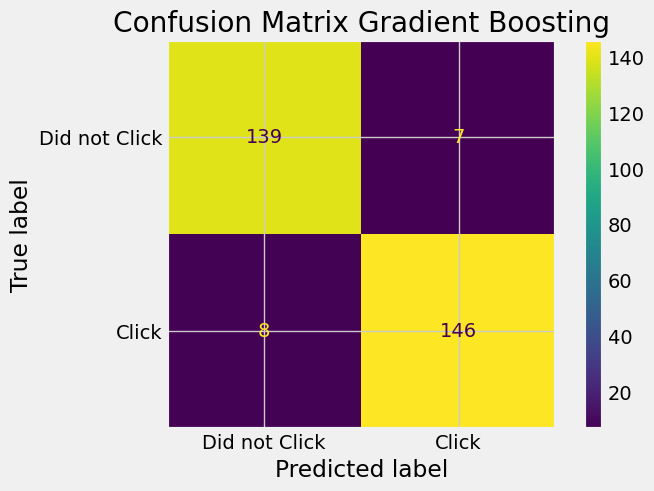

In [74]:
plot_confusion_matrix(models_dict["Gradient Boosting"], X_test, y_test, values_format='d', display_labels=['Did not Click','Click'])
plt.title("Confusion Matrix Gradient Boosting")